In [1]:
import os
import time
import torch
from torch.utils.data import  DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import utils 
from tqdm import tqdm
import pickle
from torchvision import models
import cv2 

In [2]:
torch.cuda.is_available()

True

In [3]:
TRAIN = './train_images'                  
TEST = './test_images'                      

In [4]:
TRAIN_labels = './train.csv'                    
TEST_labels = './sample_submission.csv'           

Исследуем данные 

In [5]:
train_lbls=pd.read_csv(TRAIN_labels)
train_lbls.head(5)

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

Проверим используются ли фотографии для других классов повреждений

In [6]:
train_lbls.ImageId.value_counts().reset_index(name='count')

index  count
0     ef24da2ba.jpg      3
1     db4867ee8.jpg      3
2     84865746c.jpg      2
3     5665ada1b.jpg      2
4     eb44ad79d.jpg      2
...             ...    ...
6661  59ce36e8a.jpg      1
6662  59c00ad1f.jpg      1
6663  59bcf1693.jpg      1
6664  59bc9997f.jpg      1
6665  ffffd67df.jpg      1

[6666 rows x 2 columns]

Выходит что  да

In [7]:
count_masks = pd.DataFrame({'count': train_lbls.groupby('ImageId').size()})
mod = pd.merge(train_lbls, count_masks, on='ImageId')
mod = mod.sort_values(by=['count', 'ImageId'], ascending=False)
mod['include'] = pd.Series(dtype=object)
for i, row_i in mod.iterrows():
        class_list = []
        for j, row_j in mod.loc[mod['ImageId'] == row_i['ImageId']].iterrows():
            class_list.append(row_j['ClassId'])
        mod.at[i, 'include'] = class_list
   


In [8]:
mod

ImageId  ClassId  \
6650  ef24da2ba.jpg        1   
6651  ef24da2ba.jpg        2   
6652  ef24da2ba.jpg        3   
6101  db4867ee8.jpg        1   
6102  db4867ee8.jpg        2   
...             ...      ...   
4     0014fce06.jpg        3   
3     000f6bf48.jpg        4   
2     000a4bcdd.jpg        1   
1     0007a71bf.jpg        3   
0     0002cc93b.jpg        1   

                                          EncodedPixels  count    include  
6650  366699 32 366955 32 367210 33 367466 33 367722...      3  [1, 2, 3]  
6651  366338 17 366594 50 366850 82 367106 99 367362...      3  [1, 2, 3]  
6652  178369 64 178498 191 178690 255 178946 255 179...      3  [1, 2, 3]  
6101  349941 2 350194 6 350447 11 350700 15 350953 1...      3  [1, 2, 3]  
6102  354411 17 354634 50 354857 82 355096 99 355351...      3  [1, 2, 3]  
...                                                 ...    ...        ...  
4     229501 11 229741 33 229981 55 230221 77 230468...      1        [3]  
3     131973 1 132228 4 132483 6 132738 8 132993 11 ...      1        [4]  
2     37607 3 37858 8 38108 14 38359 20 38610 25 388...      1        [1]  
1     18661 28 18863 82 19091 110 19347 110 19603 11...      1        [3]  
0     29102 12 29346 24 29602 24 29858 24 30114 24 3...      1        [1]  

[7095 rows x 5 columns]

In [9]:
mod[mod['count']==mod['count'].to_numpy().max()] #максимально сколько на  одной картинке повреждений

ImageId  ClassId  \
6650  ef24da2ba.jpg        1   
6651  ef24da2ba.jpg        2   
6652  ef24da2ba.jpg        3   
6101  db4867ee8.jpg        1   
6102  db4867ee8.jpg        2   
6103  db4867ee8.jpg        3   

                                          EncodedPixels  count    include  
6650  366699 32 366955 32 367210 33 367466 33 367722...      3  [1, 2, 3]  
6651  366338 17 366594 50 366850 82 367106 99 367362...      3  [1, 2, 3]  
6652  178369 64 178498 191 178690 255 178946 255 179...      3  [1, 2, 3]  
6101  349941 2 350194 6 350447 11 350700 15 350953 1...      3  [1, 2, 3]  
6102  354411 17 354634 50 354857 82 355096 99 355351...      3  [1, 2, 3]  
6103                              233729 3008 236801 64      3  [1, 2, 3]

In [10]:
train_lbls[train_lbls['ImageId']=='0002cc93b.jpg']	

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...

In [11]:
def counter_func(df):
    count = np.zeros(4, dtype=int)
    for i in range(4):
        try:
            index = utils.class_id2index(df.index[i])
            count[index] = df.iloc[i, 0]  
        except:
            continue
    
    return  count 

In [12]:

mask_count_df_pivot = pd.DataFrame(
    {'ClassCount': mod.groupby('ImageId').size()})
mask_count_df_pivot = pd.DataFrame(
    {'Num': mask_count_df_pivot.groupby('ClassCount').size()})
mask_count_df_pivot.sort_values('ClassCount', ascending=True, inplace=True)

ClassId_count_df = mod.set_index(
    ["ImageId", "ClassId"]).groupby(level='ClassId').count()

class_total = counter_func(ClassId_count_df)
mask_total = counter_func(mask_count_df_pivot)


In [13]:
print(class_total) 
print(mask_total) 
print(np.sum(mask_total))
print(np.sum(class_total))

[ 897  247 5150  801]
[6239  425    2    0]
6666
7095


In [14]:
print("""
      1 дефект на изображении {0},
      2 дефекта на изображении {1},
      3 дефекта на изображении {2}""".format(*mask_total))
print(np.sum(mask_total))


      1 дефект на изображении 6239,
      2 дефекта на изображении 425,
      3 дефекта на изображении 2
6666


In [15]:
print("""
      Типы дефектов кол-во
      дефект 1 класса bubbles/splashes {0},
      дефект 2 класса folds/foliations inside the metal  {1},
      дефект 3 класса scratches received during the movement of the sheet/rolled {2},
      дефект 4 класса foliations, surges, carvings, significant defects {3}  """.format(*class_total))


      Типы дефектов кол-во
      дефект 1 класса bubbles/splashes 897,
      дефект 2 класса folds/foliations inside the metal  247,
      дефект 3 класса scratches received during the movement of the sheet/rolled 5150,
      дефект 4 класса foliations, surges, carvings, significant defects 801  


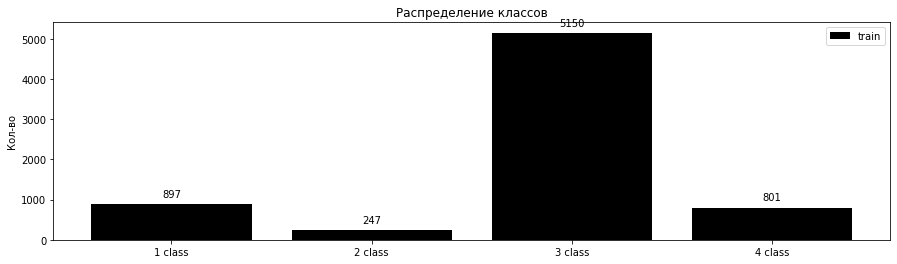

In [16]:
labels = ['1 class', '2 class', '3 class', '4 class']

fig, ax = plt.subplots(figsize=(15,4))
p1 = ax.bar(labels,class_total,  label='train', color="black")
ax.set_title('Распределение классов')
ax.set_ylabel('Кол-во')
ax.bar_label(p1, padding=5)
ax.legend()
plt.show()

In [17]:
mod_=mod.groupby('ClassId').head(247).reset_index(drop=True)

In [18]:
mod_

ImageId  ClassId  \
0    ef24da2ba.jpg        1   
1    ef24da2ba.jpg        2   
2    ef24da2ba.jpg        3   
3    db4867ee8.jpg        1   
4    db4867ee8.jpg        2   
..             ...      ...   
983  060c3159e.jpg        2   
984  060964105.jpg        2   
985  05747b10b.jpg        2   
986  0405e7c54.jpg        2   
987  026183d85.jpg        2   

                                         EncodedPixels  count    include  
0    366699 32 366955 32 367210 33 367466 33 367722...      3  [1, 2, 3]  
1    366338 17 366594 50 366850 82 367106 99 367362...      3  [1, 2, 3]  
2    178369 64 178498 191 178690 255 178946 255 179...      3  [1, 2, 3]  
3    349941 2 350194 6 350447 11 350700 15 350953 1...      3  [1, 2, 3]  
4    354411 17 354634 50 354857 82 355096 99 355351...      3  [1, 2, 3]  
..                                                 ...    ...        ...  
983  235749 28 235950 83 236151 138 236379 166 2366...      1        [2]  
984  124675 21 124931 61 125187 102 125443 142 1256...      1        [2]  
985  241477 13 241733 38 241988 64 242244 89 242500...      1        [2]  
986  9993 62 10249 186 10505 248 10761 248 11017 24...      1        [2]  
987  120132 16 120388 46 120643 78 120899 108 12115...      1        [2]  

[988 rows x 5 columns]

In [19]:
train_lbls.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [20]:
df_all_files=pd.DataFrame(os.listdir('./train_images'),columns=['all_files'])
#df_all_files.merge(train_lbls.ImageId)
df_all_files

all_files
0      0002cc93b.jpg
1      00031f466.jpg
2      000418bfc.jpg
3      000789191.jpg
4      0007a71bf.jpg
...              ...
12563  fff0295e1.jpg
12564  fff02e9c5.jpg
12565  fffe98443.jpg
12566  ffff4eaa8.jpg
12567  ffffd67df.jpg

[12568 rows x 1 columns]

In [21]:
df_all_files["IN"]=df_all_files["all_files"].isin(train_lbls["ImageId"])
df_all_files

all_files     IN
0      0002cc93b.jpg   True
1      00031f466.jpg  False
2      000418bfc.jpg  False
3      000789191.jpg  False
4      0007a71bf.jpg   True
...              ...    ...
12563  fff0295e1.jpg  False
12564  fff02e9c5.jpg   True
12565  fffe98443.jpg   True
12566  ffff4eaa8.jpg   True
12567  ffffd67df.jpg   True

[12568 rows x 2 columns]

In [22]:
tr=df_all_files.query('IN==True')
fal=df_all_files.query('IN==False')


In [23]:
tr.value_counts().values

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
fal.value_counts().values


array([1, 1, 1, ..., 1, 1, 1])

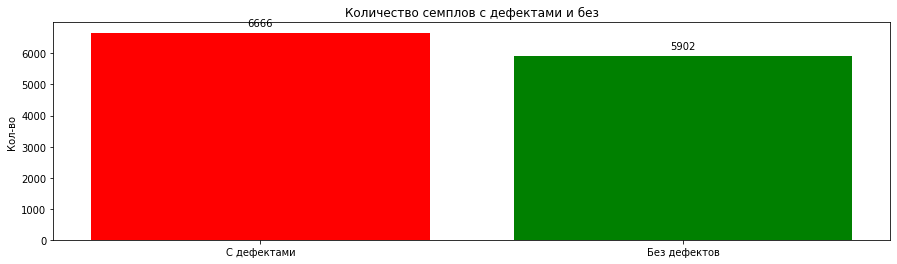

In [25]:
labels = ['С дефектами', 'Без дефектов']
fig, ax = plt.subplots(figsize=(15,4))
p1 = ax.bar(labels,[len(tr),len(fal)],  color=['red','green'])
ax.set_title('Количество семплов с дефектами и без')
ax.set_ylabel('Кол-во')
ax.bar_label(p1, padding=5)
plt.show()

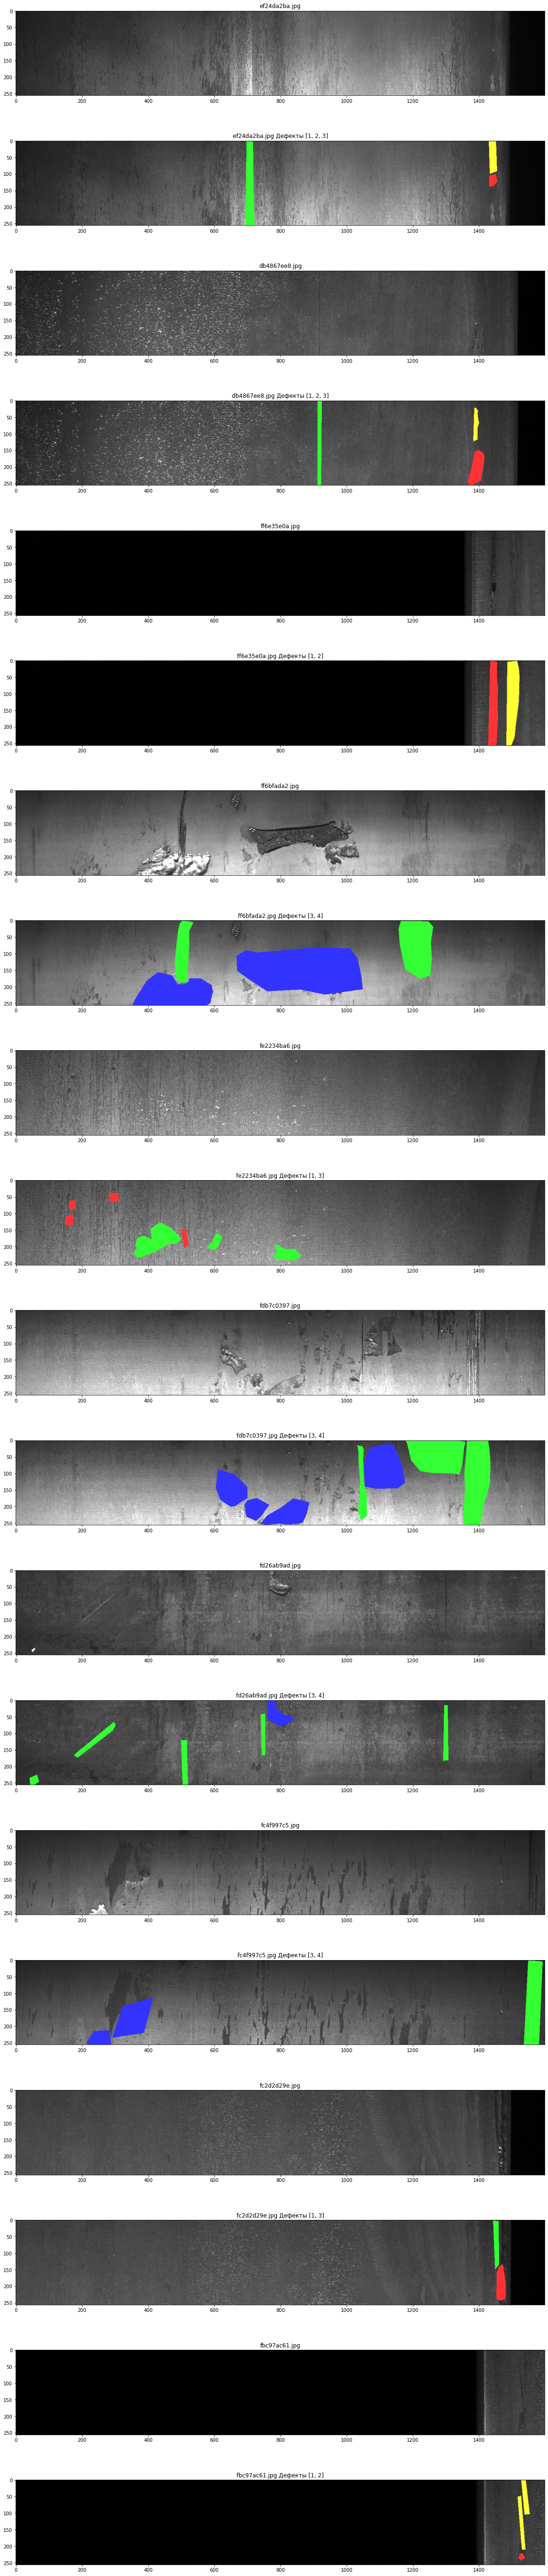

In [26]:
utils.show_images(mod, "./train_images")

In [27]:
import torch.nn.functional as F
import torchvision.transforms.functional as Transforms
class Layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Layer, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
    def forward(self, x):
        return self.conv(x)


class SegmenterModel(nn.Module):
    def __init__(self,features=[64, 128, 256, 512],in_channels=3):
        super(SegmenterModel, self).__init__()
        self.upscale = nn.ModuleList()###### для того чтобы не писать много однообразных строчек со слоями
        self.downscale = nn.ModuleList()
        ################### формируем архитектуру
        for elem in features: #### идем вниз
            self.downscale.append(Layer(in_channels, elem))
            in_channels = elem
        for elem  in reversed(features): ### идем вверх по картинке
            self.upscale.append(nn.ConvTranspose2d(
                    elem*2, elem, kernel_size=2, stride=2))
            self.upscale.append(
                Layer(elem*2,elem) 
            )
        self.pooling = nn.MaxPool2d(2, 2)
        self.bottleneck = Layer(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0],4 , 1)
        #self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):	      
        stack= []
        for down in self.downscale: # собираем 'спуск вниз'
            x = down(x)
            stack.append(x)
            x = self.pooling(x) 

        x = self.bottleneck(x) #512 1024

        stack = stack[::-1]
        for idx in range(0, len(self.upscale), 2):#собираем 'подъем'
            x = self.upscale[idx](x)
            stack_ = stack[idx//2]
            if x.shape != stack_.shape:
                x = Transforms.resize(x, size=stack_.shape[2:])
            concat_skip = torch.cat((stack_, x), dim=1)
            x = self.upscale[idx+1](concat_skip)
        return self.final_conv(x)
    
    def predict(self, x):
        # на вход подаётся одна картинка, а не батч, поэтому так
        y = self.forward(x.unsqueeze(0).cuda())
        return (y > 0).squeeze(0).squeeze(0).float().cuda()

In [28]:
SIZE=(225,450)
data=utils.data_slicer(path_data=TRAIN,df=mod,phase_in='train',batch_size=1,num_workers=4,siz=SIZE)




Feature batch shape: torch.Size([1, 3, 225, 450])
Labels batch shape: torch.Size([1, 4, 225, 450])


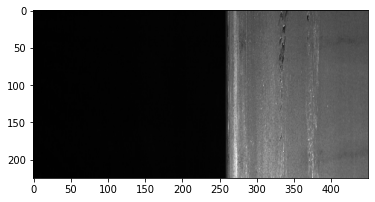

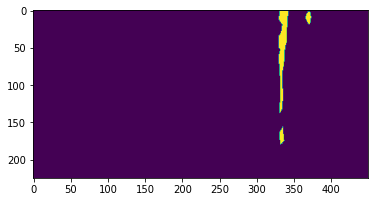

In [29]:
train_features, train_labels = next(iter(data))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]

plt.imshow(img[2],cmap="gray")
plt.show()
plt.imshow(label[2])
plt.show() 
del img,label,train_features,train_labels

In [30]:
mod.iloc[250,]

ImageId                                              bea834c94.jpg
ClassId                                                          3
EncodedPixels    6687 14 6939 41 7191 68 7443 95 7695 122 7947 ...
count                                                            2
include                                                     [3, 4]
Name: 5287, dtype: object

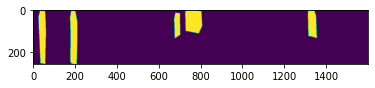

In [31]:
mask = utils.rle2mask(mod.iloc[250,2 ])
plt.imshow(mask)

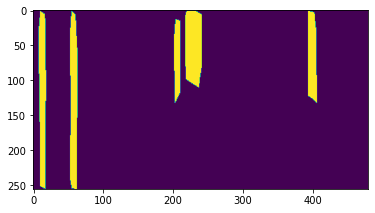

In [32]:
img=cv2.resize(np.uint8(mask).T,(256,480))
plt.imshow(img.T)

In [33]:

class Process_Driver(object):
    def __init__(self, model, input_csv_data, image_path, epochs_in,weights_path="./test",load=None):
        if load!= None:
            checkpoint = torch.load(load)
            model.load_state_dict(checkpoint['state_dict'])  
        self.df = input_csv_data
        self.num_workers = 4
        self.batch_size = {"train": 4 ,"val": 8, "test": 16}
        self.train_phases = ["train", "val"]
        self.path = image_path
        self.epochs_in = epochs_in
        self.weights = weights_path
        self.net = model
        if torch.cuda.is_available()==True:
                    self.device = "cuda:0"
        else:
                    self.device='cpu'
        print (f'Тренировка на : {self.device}')

        self.dataloader = {
            phase: utils.data_slicer(
                path_data=image_path,
                df=self.df,
                phase_in=phase,
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,siz=SIZE
            )
            for phase in self.train_phases
        }

    def forward(self, images, targets=None):
        if targets is None:
            targets_shape = list(images.shape) 
            targets_shape[1] = 4
            targets = torch.zeros(*targets_shape)
        else:
            targets = targets

        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)

        if targets is None:
            loss = None
        else:
            loss = self.criterion(outputs, masks)
        return loss, outputs


    def iterate(self, epoch, phase):
        meter = utils.Metrix(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | Этап: {phase} | started at: {start}")
        self.net.train(phase == "train")
        dataloader = self.dataloader[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk_dm = tqdm(dataloader, total=total_batches) 
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk_dm):
            images, targets = batch

            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()  # обнуляем градиент для каждого батча
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk_dm.set_postfix(BCE_loss=(running_loss / ((itr + 1)))) 
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        iou,epoch_acc= utils.epoch_log(phase, epoch, self.last_lr, epoch_loss, meter)
        if phase == 'train':
            self.lr_rates.append(self.last_lr)

        self.losses[phase].append(epoch_loss)
        self.iou_scores[phase].append(iou)
        self.dice[phase].append(epoch_acc)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
            
            self.lr = 0.001
            self.gamma = 0.001
            self.last_lr = float(self.lr)
            self.num_epochs = self.epochs_in 
            self.best_loss = float("inf")
            self.accumulation_steps = 32 // self.batch_size['train']
            self.criterion = nn.BCEWithLogitsLoss() #
            self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr) #
            # постепенно снижаем lr из эпохи в эпоху
            self.down_lr = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=self.gamma) 
            # Плато
            self.plato = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", patience=2, factor=0.1, verbose=True)
            self.best_ago_max = 5 
            self.best_ago = 0 
            self.net = self.net.to(self.device)
            self.losses = {phase: [] for phase in self.train_phases}
            self.iou_scores = {phase: [] for phase in self.train_phases}
            self.dice = {phase: [] for phase in self.train_phases}
            self.lr_rates = []

            for epoch in range(self.num_epochs):
                self.iterate(epoch, "train")
                state = {
                    "epoch": epoch,
                    "best_loss": self.best_loss,
                    "state_dict": self.net.state_dict(),
                    "optimizer": self.optimizer.state_dict(),
                }
                with torch.no_grad():
                    val_loss = self.iterate(epoch, "val")

                    self.plato.step(val_loss)
                    self.down_lr.step()
                    self.last_lr = min(float(self.plato.optimizer.param_groups[0]['lr']), float(self.down_lr.get_last_lr()[0]))
                if val_loss < self.best_loss:
                    print("******** Новая оптимальная модель ********")
                    state["best_loss"] = self.best_loss = val_loss
                    torch.save(state, f'{self.weights}{epoch}__{self.best_loss}.pt')
                    self.best_ago = 0
                else:
                    self.best_ago += 1

                if self.best_ago == self.best_ago_max:
                    print(f'Early stopping at epoch {epoch}')
                    torch.save(state, f'{self.weights}{epoch}_last__{self.best_loss}.pt')
                    break

            model_results = {
                'losses' : self.losses,
                'iou_scores' : self.iou_scores,
                'lr_rates' : self.lr_rates,
                'dice_acc_scores':self.dice
            }

            with open(self.weights, 'wb') as fp:
                pickle.dump(model_results, fp)










In [34]:
model_=SegmenterModel()




In [35]:
model_trainer = Process_Driver(model = model_ ,input_csv_data = mod_ ,image_path = './train_images',epochs_in = 10,  weights_path = 'weights')

Тренировка на : cuda:0


In [36]:
#model_trainer.start()
#torch.cuda.empty_cache()

In [37]:
def  check(file):
      epoch = file['losses']['val'].index(min(file['losses']['val']))
      bce_loss = file['losses']['val']
      iou_scores = file['iou_scores']['val']
      dice_scores = file['acc_scores']['val']
      return epoch,bce_loss,iou_scores,dice_scores

In [38]:
test = pd.read_csv(TEST_labels)
test

ImageId EncodedPixels  ClassId
0     0000f269f.jpg      1 409600        0
1     000ccc2ac.jpg      1 409600        0
2     002451917.jpg      1 409600        0
3     003c5da97.jpg      1 409600        0
4     0042e163f.jpg      1 409600        0
...             ...           ...      ...
5501  ffc9a6187.jpg      1 409600        0
5502  ffdb60677.jpg      1 409600        0
5503  ffe6e2da6.jpg      1 409600        0
5504  fff4fd9bb.jpg      1 409600        0
5505  fff598023.jpg      1 409600        0

[5506 rows x 3 columns]

In [39]:

class Test(Process_Driver):
    def __init__(self, model_in, df_in, image_root, epochs_in ,weights_root_in):
        self.criterion = nn.BCEWithLogitsLoss()
        self.df_local = df_in
        self.num_workers = 2
        self.batch_size = {"test": 16}
        self.image_root = image_root
        self.epochs_in = epochs_in

        self.device = 'cuda:0'
        print (f'Test on device: {self.device}')

        self.weigths_root = weights_root_in
        self.net = model_in

        self.dataloader = utils.data_slicer(self.image_root,df_in,'test',self.batch_size['test'],self.num_workers,siz=SIZE)

    def process(self, probability, threshold, min_size):

        mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1] 
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros(SIZE, np.float32)

        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > min_size:
                predictions[p] = 1 
        return predictions

    def rle_encode(self, fnames, batch_preds):
        for fname, pred_mask in zip(fnames, batch_preds):
            for cls, pred_mask in enumerate(pred_mask):
                pred_mask = self.process(pred_mask, self.best_threshold, self.min_size) 
                rle = utils.mask2rle(pred_mask)
                if rle != '':
                    cls =  utils.index2class_id(cls)
                    pred_loc = [fname, cls, rle]
                    self.predicted_pixels.append(pred_loc)

    def iterate(self, epoch: int, phase: str):
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | started at: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "test")
        dataloader = self.dataloader
        total_batches = len(dataloader)

        for itr, batch in enumerate(tqdm(dataloader, total=total_batches)): # replace `dataloader` with `tk0` for tqdm
            fnames, images = batch

            _, outputs = self.forward(images)
            outputs = torch.sigmoid(outputs)
            # пропустили через  активатор-сигмойду 

            outputs = outputs.detach().cpu().numpy()

            self.rle_encode(fnames, outputs)

        torch.cuda.empty_cache()


    def start(self):
        self.state = torch.load(self.weigths_root)
        self.net.to(self.device)  #

        self.net.load_state_dict(self.state["state_dict"])

        self.min_size = 50 

        self.best_threshold = 0.25 
        self.predicted_pixels = [] 


        with torch.no_grad():
            self.iterate(0, "test")
        self.df = pd.DataFrame(self.predicted_pixels, columns=['ImageId', 'ClassId', 'EncodedPixels'])
        self.df.to_csv("./ok.csv", index=False)

In [40]:
first_parameter = next(model_.parameters())
input_shape = first_parameter.size()
input_shape 

torch.Size([1024, 512, 2, 2])

In [41]:
test_df=pd.read_csv('./sample_submission.csv')

In [42]:
test = Test(model_,test_df,  TEST, 0 ,'./weights.pt')

#test.start()

Test on device: cuda:0
            ImageId EncodedPixels  ClassId
0     0000f269f.jpg      1 409600        0
1     000ccc2ac.jpg      1 409600        0
2     002451917.jpg      1 409600        0
3     003c5da97.jpg      1 409600        0
4     0042e163f.jpg      1 409600        0
...             ...           ...      ...
5501  ffc9a6187.jpg      1 409600        0
5502  ffdb60677.jpg      1 409600        0
5503  ffe6e2da6.jpg      1 409600        0
5504  fff4fd9bb.jpg      1 409600        0
5505  fff598023.jpg      1 409600        0

[5506 rows x 3 columns]


In [43]:
import pickle 
file=open("stat_of_model",'rb')
file=pickle.load(file)
file

{'losses': {'train': [0.5219921434562994,
   0.3899005786119471,
   0.33072584573228686,
   0.29622784080852044,
   0.2757191711540034,
   0.26329839145866635,
   0.2555582951335336,
   0.2506303389370526,
   0.2474189665053317,
   0.24536368550041499],
  'val': [0.44147372776475197,
   0.34867561504761163,
   0.30563841502314043,
   0.28167654425323885,
   0.2649231463974522,
   0.25573546541829795,
   0.2500311062291805,
   0.2453483665848623,
   0.24423860599652378,
   0.24255594644962047]},
 'iou_scores': {'train': [0.030282902,
   0.47736958,
   0.49952203,
   0.52274233,
   0.53347427,
   0.53611547,
   0.5392823,
   0.5420984,
   0.5426241,
   0.5426245],
  'val': [0.19437008,
   0.564661,
   0.5899201,
   0.58713126,
   0.597177,
   0.5997397,
   0.59015673,
   0.59857315,
   0.5911151,
   0.58738047]},
 'lr_rates': [0.0001,
  6.500000000000001e-05,
  4.2250000000000004e-05,
  2.7462500000000003e-05,
  1.7850625000000003e-05,
  1.1602906250000002e-05,
  7.541889062500002e-06,
 

In [ ]:
epoch,bce_loss_val,iou_scores_val,dice_scores_val=check(file)

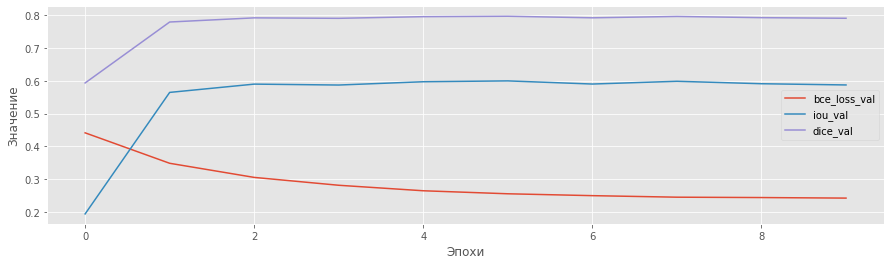

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = np.arange(0, epoch+1)
plt.style.use("ggplot")
plt.figure(figsize=(15,4)) 
plt.plot(N,  bce_loss_val, label="bce_loss_val")
plt.plot(N, iou_scores_val, label="iou_val")
plt.plot(N, dice_scores_val, label="dice_val")
plt.xlabel("Эпохи")
plt.ylabel("Значение")
plt.legend()